# Posterior Predictive

In [3]:
"""Bayesian Linear Regression"""
import minipyro as pyro
import torch

from torch.distributions import constraints
import pyro.distributions as pdist

import plots

In [99]:
def random_sample(t, k):
  x, y = t
  indices = torch.randperm(len(x))
  return x[indices][:k], y[indices][:k]


def noisy():
  x = torch.arange(-2, 2, 0.01)
  w, b = 2., 1.
  # y = w * x + b + torch.normal(torch.tensor(0.), torch.tensor(1.))
  print('TRUE DISTRIBUTION : {w}x + {b}'.format(w=w, b=b))
  x, y = random_sample((x, y), len(x))
  k = int(len(x) * 0.8)

  return (x[:k], y[:k]), (x[k:], y[k:])


def model(x, y):
  w = pyro.sample('w', pdist.Normal(0., 1.))
  b = pyro.sample('b', pdist.Normal(0.5, 1.))
  # define model
  mean = w * x + b
  # mean = w * x + 0.3
  # variance of distribution centered around y
  # sigma = pyro.sample('sigma', pdist.Normal(0., 0.01))
  pyro.sample('obs', pdist.Normal(mean, 0.01), obs=y)
  return mean


def guide(x, y):
  # parameters of (w : weight)
  w_loc = pyro.param('w_loc', torch.tensor(1.))
  w_scale = pyro.param('w_scale', torch.tensor(1.),
      constraint=constraints.positive
      )
  # parameters of (b : bias)
  b_loc = pyro.param('b_loc', torch.tensor(0.))
  b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
  # parameters of (sigma)
  # sigma_loc = pyro.param('sigma_loc', torch.tensor(0.), constraint=constraints.positive)  # .exp()

  # sample (w, b, sigma)
  w = pyro.sample('w', pdist.Normal(w_loc, w_scale))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale))
  # sigma = pyro.sample('sigma', pdist.Normal(sigma_loc, torch.tensor(0.05)))

TRUE DISTRIBUTION : 2.0x + 1.0
W(LOC) :  2.0033202171325684 0.05776231363415718
b(LOC) :  1.843946933746338 0.06792589277029037


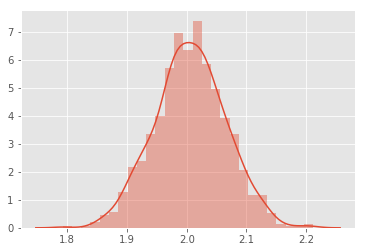

In [100]:
# generate data
(train_x, train_y), (test_x, test_y) = noisy()

# clear parameter store
pyro.PARAM_STORE.clear()

# learning rate
lr = 0.005
# training steps
num_steps = 5000

# SVI for inference
svi = pyro.SVI(model, guide, optimizer=pyro.Adam({'lr' : lr}), loss_fn=pyro.elbo)

losses, w, b = [], [], []
for step in range(num_steps):
    loss = svi.step(train_x, train_y)
    # if step % 100 == 0:
    losses.append(loss)
    w.append(pyro.param('w_loc').item())
    b.append(pyro.param('b_loc').item())

# if step % 100 == 0:
#   print('[{}] loss : {}'.format(step, loss))

print('W(LOC) : ', pyro.param('w_loc').item(), pyro.param('w_scale').item())
print('b(LOC) : ', pyro.param('b_loc').item(), pyro.param('b_scale').item())
# print('sigma(LOC) : ', pyro.param('sigma_loc').item())

# plots.elbo(losses)
# plots.param(w, 2., name='w')
# plots.param(b, 1., name='b')
plots.density_plot(
  plots.sample_normal(
    pyro.param('w_loc').item(),
    pyro.param('w_scale').item(),
    N=1000
    )
  )

In [9]:
import torch.distributions as tdist

In [101]:
def prob_forward(x):
    w = tdist.Normal(pyro.param('w_loc'), pyro.param('w_scale'))
    b = tdist.Normal(pyro.param('b_loc'), pyro.param('b_scale'))
    return w.sample(x.size()) * x + b.sample(x.size())

In [102]:
predictions = prob_forward(train_x[:10])

In [114]:
samples = 100
x_tmp = torch.linspace(-2, 2, 100).reshape(-1, 1)
y_samp = np.zeros((samples, 100))
for s in range(samples):
    y_tmp = prob_forward(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)

In [48]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

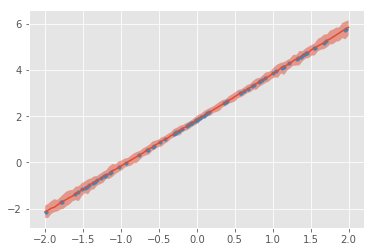

In [123]:
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis=0), label='Mean Posterior Predictive')
plt.fill_between(
    x_tmp.numpy().reshape(-1),
    np.percentile(y_samp, 0., axis=0),
    np.percentile(y_samp, 99.5, axis = 0),
    alpha = 0.5, label='95% Confidence'
)
plt.scatter(train_x[:80], train_y[:80], s=12)